# Training Notebook Schema

After running the EDA analysis, the next step is to train a model to detect hate speech. This notebook will be used to define the model architecture, train the model, evaluate its performance, and potentially improve it. The notebook will be structured as follows:

#### Setup
   - Import necessary libraries and define global configurations

#### Data Preparation
   - Load the cleaned and preprocessed data.
   - Split data into training, validation, and test sets.

#### Model Training
   - We are going to try 3 different approaches:  
         - TF-IDF + Logistic Regression model
         - BCE Embeddings + Logistic Regression model
         - Fine tuned BCE Embeddings + Logistic Regression model
   - For each of them we are going to evaluate the model using the test set. 

#### Future Work
   - Discuss potential improvements and future directions for the project.

# Setup 

In [1]:
import os
import random
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from sentence_transformers.datasets import NoDuplicatesDataLoader
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump
import torch 
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlosmorales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preparations

In [3]:
df_train = pd.read_parquet("../data/train.parquet").reset_index(drop=True)
display(df_train.shape) 
df_train.head(3)

(3998, 6)

,comment_id,user_id,subforum_id,text,label,num_contexts
0,31768437,585713,1363,the only way we can win is by opening the eyes...,False,0
1,13594695,589961,1393,Maybe some of you people should grow up You do...,False,0
2,13470210,572059,1346,Deuteronomy <NUMBER> <NUMBER> God speaking to ...,True,0


In [4]:
df_test = pd.read_parquet("../data/test.parquet").reset_index(drop=True)
display(df_test.shape) 
df_test.head(3)

(1000, 6)

,comment_id,user_id,subforum_id,text,label,num_contexts
0,14666244,614195,1371,Hopefully these video s can wake you all up ab...,False,0
1,13291133,573473,1345,Not only is this case typical of the feral sub...,True,0
2,13082561,576531,1345,Sergey Brin claims his family were victims of ...,False,0


In [5]:
X_train, y_train = df_train['text'], df_train['label']
X_test, y_test = df_test['text'], df_test['label']

# Model Training 

 We are going to explore different modeling approaches to evaluate their performance variations. 

  - Firstly, we will establish a baseline using a traditional method: **TF-IDF** for numeric representation of text data, followed by a Logistic Regression model to perform classification.

  - Secondly, we will employ a **pre-trained embeddings** model directly (without any fine-tuning) and apply a Logistic Regression model to classify based on these embeddings.

  - Thirdly, we will take a **pre-trained embeddings model, fine-tune** it specifically for our dataset, and then use a Logistic Regression model for classification.

 Additionally, for more complex scenarios, we could replace the Logistic Regression with more sophisticated models such as Support Vector Machines (SVM), Random Forests, or even neural network architectures to potentially improve performance.


## TF-IDF

In [6]:
# Load English stopwords
english_stopwords = stopwords.words('english')

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=english_stopwords, max_features=5000)

# Create a Complement Naive Bayes classifier, suitable for imbalanced datasets
bayesian_classifier = BernoulliNB()

# Create a pipeline to vectorize and then run the Bayesian classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', bayesian_classifier)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model over training data
y_pred = pipeline.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      3140
        True       0.88      0.62      0.73       858

    accuracy                           0.90      3998
   macro avg       0.89      0.80      0.83      3998
weighted avg       0.90      0.90      0.89      3998



In [7]:
# Evaluate the model over test data
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.94      0.89       785
        True       0.62      0.34      0.44       215

    accuracy                           0.81      1000
   macro avg       0.73      0.64      0.66      1000
weighted avg       0.79      0.81      0.79      1000



In [8]:
def plot_confusion_matrix(y_test, y_pred):
    """
    Computes and visualizes the confusion matrix.

    Args:
    y_test (array-like): True labels of the test set.
    y_pred (array-like): Predicted labels by the model.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



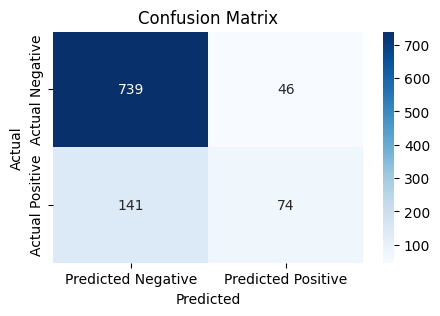

In [9]:
plot_confusion_matrix(y_test, y_pred)

# BGE Embedding Model 

In [10]:
model_name_hf = "BAAI/bge-large-en-v1.5"

# Load the Sentence Transformer model
model = SentenceTransformer(model_name_hf)

def text_to_embedding(text):
    "Function to convert text data into embeddings using a loaded model"
    return model.encode(text, convert_to_tensor=True).cpu()

/Users/carlosmorales/Library/Caches/pypoetry/virtualenvs/carlos-morales-nlp-assignment-TEig4pQx-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
%%time

# Create a Logistic Regression classifier
logistic_classifier = LogisticRegression()

# Create a pipeline to convert text to embeddings and then run the Logistic classifier
pipeline = Pipeline([
    ('embedding', FunctionTransformer(text_to_embedding)),
    ('classifier', logistic_classifier)
])

X_train = df_train['text'].reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model over training data
y_pred = pipeline.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92      3140
        True       0.81      0.52      0.63       858

    accuracy                           0.87      3998
   macro avg       0.84      0.74      0.78      3998
weighted avg       0.86      0.87      0.86      3998

CPU times: user 17.1 s, sys: 6.03 s, total: 23.1 s
Wall time: 1min 4s


In [12]:
# Evaluate the model over test data
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.95      0.91       785
        True       0.74      0.52      0.61       215

    accuracy                           0.86      1000
   macro avg       0.81      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000



Here we almost dont see any differece because we haven't trained the embedding model, only the logistic regression model.

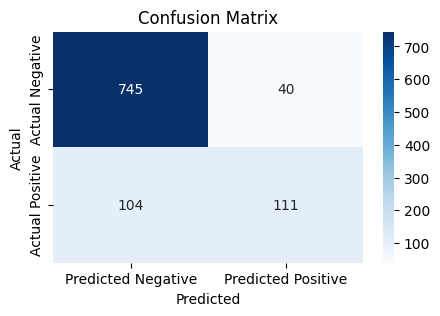

In [13]:
plot_confusion_matrix(y_test, y_pred)


# Fine-tune Embedding Model

In [14]:
# Fine-tune the Embedding Model
model_name_hf = "BAAI/bge-large-en-v1.5"
model = SentenceTransformer(model_name_hf)


/Users/carlosmorales/Library/Caches/pypoetry/virtualenvs/carlos-morales-nlp-assignment-TEig4pQx-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Let's prepare the data for training with BatchHardSoftMarginTripletLoss by ensurin:
  - the labels are integers 
  - and creating a list of InputExample objects from out comments.  A list of (Tex, Label)


In [15]:
df_train['label'] = df_train['label'].astype(int)
train_dataset = [InputExample(texts=[text], label=label) for text, label in zip(df_train['text'], df_train['label'])]

df_test['label'] = df_test['label'].astype(int)
test_dataset = [InputExample(texts=[text], label=label) for text, label in zip(df_test['text'], df_test['label'])]

In [16]:
model_name_hf = "BAAI/bge-large-en-v1.5"
model = SentenceTransformer(model_name_hf)

/Users/carlosmorales/Library/Caches/pypoetry/virtualenvs/carlos-morales-nlp-assignment-TEig4pQx-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
# Create the evaluator with randomized sentence pairs
random_test_dataset = random.sample(test_dataset, len(test_dataset))

evaluator = BinaryClassificationEvaluator(
    sentences1=[example.texts[0] for example in test_dataset],
    sentences2=[example.texts[0] for example in random_test_dataset],
    labels=[example.label for example in test_dataset],
    name='accuracy-eval'
)


To enhance the training process, we will utilize:
 
  - **BatchHardSoftMarginTripletLoss**: This loss function processes a batch of (sentence, label) pairs, calculating the loss across all valid triplets. For a triplet to be valid, the anchor and positive must share the same label, while the anchor and negative must have different labels. This approach is particularly effective for binary classification tasks like ours, helping to mitigate the effects of class imbalance.
 
 - **Matryoshka2dLoss**: This method reduces the dimensionality of embeddings but maintains most of the original performance. It helps in building a more robust classifier using the reduced-dimension embeddings.


In [18]:
%%time

## 15 mins 

torch.mps.empty_cache()

train_batch_size = 4
epochs = 2

train_dataloader = NoDuplicatesDataLoader(train_examples=train_dataset, batch_size=train_batch_size)

train_loss = losses.BatchHardSoftMarginTripletLoss(model=model)
train_loss = losses.Matryoshka2dLoss(model, train_loss, [1024, 256, 128, 64])


warmup_steps = math.ceil(len(train_dataloader) * epochs * 0.1)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=epochs,
    warmup_steps=warmup_steps,
    use_amp=False, 
    optimizer_params={'lr': 1e-5},
    show_progress_bar=True,
)


model_save_path = f'../models/{model_name_hf}_finetuned'
model.save(model_save_path)


NameError: name 'math' is not defined

Note: we are using Matryoshka Representation Learning to be able to truncate the dimensions on the embedding to reduce the dimensionality of the embeddings. 

The main goal of this is to make the problem to solve by the logistic classifier a bit easier.

In [19]:
matryoshka_dim = 64
# Load the fine-tuned model
model = SentenceTransformer(model_save_path, truncate_dim=matryoshka_dim)

# Function to convert text to embeddings using the fine-tuned model
def text_to_finetuned_embedding(text):
    return model.encode(text, convert_to_tensor=True).cpu()

# Create a Logistic Regression classifier
logistic_classifier = LogisticRegression()

# Create a pipeline to convert text to fine-tuned embeddings and then run the Logistic classifier
pipeline = Pipeline([
    ('embedding', FunctionTransformer(text_to_finetuned_embedding)),
    ('classifier', logistic_classifier)
])

X_train = df_train['text'].reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Saving the logistic regression classifier 
logistic_classifier = pipeline.named_steps['classifier']
dump(logistic_classifier, '../models/logistic_regression_classifier.joblib')

# Evaluate the model over training data
y_pred = pipeline.predict(X_train)
print(classification_report(y_train, y_pred))

NameError: name 'model_save_path' is not defined

In [ ]:
# Evaluate the model over test data
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(y_test, y_pred)

# Model Comparison 

We are going to focus on macro f1-score. This is a good metric because it takes into account the imbalance of the classes being is the average of the f1-scores of each class.

We have the following metrics evaluated over the test data for the different approaches:
  - **TF-IDF + Logistic Regression** = 0.64
  - **BGE Embedding + Logistic Regression** = 0.76
  - **Fine-tuned BGE Embedding + Logistic Regression** = 0.81


This is not surprising as naive approaches like TF-IDF are good at detecting keywords but are not able to capture the complexity of the language, so when using more complex models, specially when we train our own embedding system, we get better results. 

Also it is noteworthy that the fine-tuned model has substantially increased the recall for the hate speech class (0.71), which is the most important class to detect.

In conclusion, the fine-tuned model is the best performing model, and this is the one we are going to deploy. 

# Saving results 

We are going to save the results of the fine-tuned model over the test dataset:


In [ ]:
df_test['predicted_label'] = y_pred
df_test.to_csv("../results/predictions_over_test.csv", index=False)

# Further Work

 Due to time constraints and limited resources (running on CPU), we are concluding the training section here. However, there are several strategies to consider for enhancing model performance in future developments:

 - Hyper parameter tuning for the logistic regression model to enhance its predictive accuracy. 
 
 - Experiment with more complex models such as Support Vector Machines (SVM), Random Forests, or neural network architectures to potentially improve performance.

 - Adjust the training parameters of the pre-trained embeddings model, such as increasing the number of epochs or modifying the learning rate, to see if there are performance gains.

 - Explore the use of more powerful models like DistilBert or recently introduced small LLMs such as Gemma or Phi-3. We have not tried any of those because their size is too big for CPU training.
